# Group 14 - Project FP01
## Time series anomaly detection - Random Forest Classifier

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# %pip install --no-binary :all: -r requirements.txt

In [2]:
# %pip install numpy==1.26.4
# %pip install pandas==1.5.3
# %pip install tensorflow
# %pip install tsfel
# %pip install keras_tuner
# %pip install -U kaleido
# %pip install seaborn
# %pip install plotly
# %pip install openpyxl

In [3]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from src.dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data
from src.plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from src.metrics import Confidence, anomaly_detection_metric, compute_metrics

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  './dataset/normal' #'/content/drive/MyDrive/dataset/normal'
ROOTDIR_DATASET_ANOMALY = './dataset/collisions'#'/content/drive/MyDrive/dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [6]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = collision_rec1
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [7]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 177.14164853096008 seconds ---


In [8]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [9]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
y_test_collision = df_with_labels["is_collision"]

Trying to take collision_zones



In [10]:
ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()

d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
collision_zones = pd.DataFrame(d)


## Random Forest

In [11]:
num_estims = [10, 100, 1000]
crits = ['gini', 'entropy', 'log_loss']
max_dept = [None, 50, 100, 1000]
min_s_splits = [2, 3]
max_features = ['sqrt', 'log2', None]

classifier = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = 1000,
    min_samples_split = 2,
    max_features = 'sqrt'
    )
# Train the RandomForestClassifier on normal data
classifier.fit(X_train, y_train)
print("Random Forest training completed.")

Random Forest training completed.


### Anomaly Detection

In [22]:
anomaly_scores = None
try:
    anomaly_scores = classifier.predict_proba(X_test)
    # Replace inf values with the maximum float value
    anomaly_scores = np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min)
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")
    # If an error occurs, you might want to inspect the model's internal state
print("Anomaly prediction completed.")

Anomaly prediction completed.


In [25]:
anomaly_scores.shape

(306, 31)

In [26]:
threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

In [27]:
median = np.median(anomaly_scores)
mad = np.median(np.abs(anomaly_scores - median))
threshold_2 = median + 3 * mad

In [28]:
threshold_3 = np.percentile(anomaly_scores, 95)

In [29]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

In [30]:
for threshold in [threshold_1, threshold_2, threshold_3, threshold_4]:
    anomalies_detected = sum(anomaly_scores >= threshold)
    print(f"Number of anomalies detected: {anomalies_detected} with threshold {threshold}")

Number of anomalies detected: [11  6  2 17 14  4  5 18 13  7  7 19  9  5  3  4  5  5  5  4  4  4  3  5
  4  5  4  6  3  4  3] with threshold 0.2740876850403273
Number of anomalies detected: [306 306 306 306 306 306 306 306 306 306 306 306 306 306 306 306 306 306
 306 306 306 306 306 306 306 306 306 306 306 306 306] with threshold 0.0
Number of anomalies detected: [20 16 10 47 31  8 12 39 25 34 13 50 29 16  6 12  8 16 12  6  5  5  6 17
 12  7  5  7  7  9  4] with threshold 0.11
Number of anomalies detected: [60 36 30 72 59 26 24 65 78 65 35 69 55 34 30 39 21 48 29 16 17 24 28 92
 37 30 16 18 23 40 14] with threshold 0.05


ValueError: x and y must be the same size

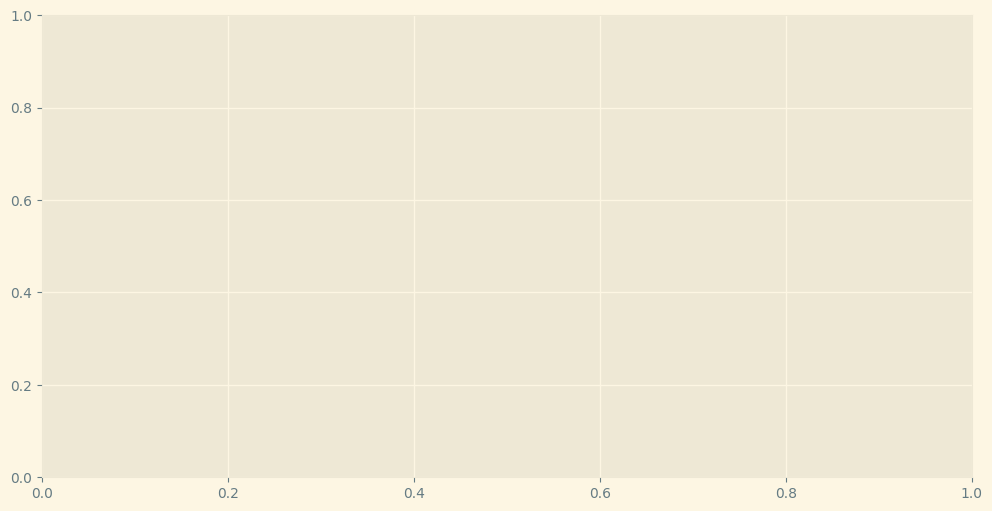

In [31]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2, "RANDOM FOREST")

In [ ]:
# for classifier in fitted_clfs:
#   print("-------------------------------------------- New classifier --------------------------------------------")
compute_metrics(anomaly_scores, y_test_collision, threshold_2)

In [ ]:
plot_roc_curve(y_test_collision.values, anomaly_scores)

## Map anomalies to original time series

In [ ]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, threshold_2, collision_zones, X_test_start_end)